# **Préparer les données**

### **Monter le dossier dans Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

### **Importation de quelques librairies**

In [ ]:
import numpy as np
import tifffile
import glob
from pathlib import Path
import pandas as pd

### **Lecture de la série temporelle d'images et Normalisation par bande sur la série temporelle entre 0 et 1** 

#### **Lecture des images et création des séries temporelles de bandes**

In [ ]:
# Récupérer la liste des images
lst_img = glob.glob ('Images/*.tif')
lst_img.sort() # ordonner par date si ce n'est pas le cas
lst_img

['Images/20160322_S2A.tif',
 'Images/20160710_S2A.tif',
 'Images/20160730_S2A.tif',
 'Images/20160928_S2A.tif',
 'Images/20161018_S2A.tif',
 'Images/20161127_S2A.tif',
 'Images/20161217_S2A.tif',
 'Images/20161227_S2A.tif']

In [ ]:
# Lecture de la bande du rouge (B1) pour toute la série temporelle
red_ts = []
for img in lst_img:
  red_ts.append( tifffile.imread(img)[:,:,0]) # Rouge
red_ts = np.dstack(red_ts)
red_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du vert (B2) pour toute la série temporelle
green_ts = []
for img in lst_img:
  green_ts.append( tifffile.imread(img)[:,:,1]) # Vert
green_ts = np.dstack(green_ts)
green_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du bleu (B3) pour toute la série temporelle
blue_ts = []
for img in lst_img:
  blue_ts.append( tifffile.imread(img)[:,:,2]) # Bleu
blue_ts = np.dstack(blue_ts)
blue_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du proche infrarouge (B4) pour toute la série temporelle
nir_ts = []
for img in lst_img:
  nir_ts.append( tifffile.imread(img)[:,:,3]) # Proche infra rouge
nir_ts = np.dstack(nir_ts)
nir_ts.shape

(5412, 5592, 8)

In [ ]:
# Calculer des indices spectraux comme le NDVI
ndvi_ts = np.where(nir_ts + red_ts == 0, 0, (nir_ts - red_ts) / (nir_ts + red_ts)).astype(np.float32)
ndvi_ts.shape, ndvi_ts.dtype, ndvi_ts.min(), ndvi_ts.max()

((5412, 5592, 8), dtype('float32'), -0.9994976, 0.99976385)

#### **Normalisation en utilisant le min et le max des bandes sur les séries temporelles**

In [ ]:
# Normalisation des séries temporelles par bande: Rouge
red_ts_norm = ( red_ts - red_ts.min() ) / ( red_ts.max() - red_ts.min() ).astype(np.float32)
red_ts_norm.min() , red_ts_norm.max(), red_ts_norm.shape, red_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Vert
green_ts_norm = ( green_ts - green_ts.min() ) / ( green_ts.max() - green_ts.min() ).astype(np.float32)
green_ts = None
green_ts_norm.min() , green_ts_norm.max(), green_ts_norm.shape, green_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Bleu
blue_ts_norm = ( blue_ts - blue_ts.min() ) / ( blue_ts.max() - blue_ts.min() ).astype(np.float32)
blue_ts = None
blue_ts_norm.min() , blue_ts_norm.max(), blue_ts_norm.shape, blue_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Proche infrarouge
nir_ts_norm = ( nir_ts - nir_ts.min() ) / ( nir_ts.max() - nir_ts.min() ).astype(np.float32)
nir_ts_norm.min() , nir_ts_norm.max(), nir_ts_norm.shape, nir_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normaliser les indices spectraux que vous aurez calculé
ndvi_ts_norm = ( ndvi_ts - ndvi_ts.min() ) / ( ndvi_ts.max() - ndvi_ts.min( )).astype(np.float32)
ndvi_ts_norm.min(), ndvi_ts_norm.max(), ndvi_ts_norm.shape, ndvi_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

### **Lecture de la vérité terrain et récupération des positions des pixels du jeu d'entraînement et de test**

#### **Lecture des fichiers de la vérité terrain**

In [ ]:
# Lire le fichier correspondant aux classes d'occupation du sol
gt_class = tifffile.imread ('Verite_terrain/DORDOGNE_VT_CLASS.tif')
gt_class.shape , gt_class.dtype

((5412, 5592), dtype('uint8'))

In [ ]:
# Lire le fichier correspondant aux identifiants
gt_id = tifffile.imread ('Verite_terrain/DORDOGNE_VT_ID.tif')
gt_id.shape, gt_id.dtype

((5412, 5592), dtype('int16'))

#### **Récupération des positions des pixels d'entraînement et de test**

In [ ]:
# Récupérer les positions des échantillons d'entraînement et test
idx_train_ = np.where ( (gt_id!=0) & (gt_class!=0) )
idx_test = np.where ( (gt_id!=0) & (gt_class==0) )

In [ ]:
# Lecture des identifiants et labels des échantillons d'entraînement
train_id_ = gt_id[idx_train_]
train_y_ = gt_class[idx_train_]
f'échantillons d\'entrainement: {train_y_.shape[0]} pixels, {len(np.unique(train_id_))} objets'

"échantillons d'entrainement: 605431 pixels, 1859 objets"

In [ ]:
# Lecture des identifiants et labels des échantillons de test
test_id = gt_id[idx_test]
f'échantillons test: {test_id.shape[0]} pixels, {len(np.unique(test_id))} objets'

'échantillons test: 207485 pixels, 800 objets'

### **Création d'un jeu de validation en prenant une partie du jeu d'entraînement**
Pour cela, on s'assure de faire la division en mettant les pixels ayant le même identifiant dans un seul et même lot

In [ ]:
# Dataframe pour créer un jeu de validation
samples = pd.DataFrame({'ID':train_id_,'Class':train_y_})
samples = samples.drop_duplicates(keep='first')
samples.head(5)

,ID,Class
0,422,2
4,2677,5
5,201,3
29,423,2
100,496,2


In [ ]:
# 30% des échantillons de chaque classe affecté au jeu de validation
train_id = []
valid_id = []
for c in np.unique(samples.Class.values) :
    samples_c = samples.loc[samples.Class==c]
    samples_frac = samples_c.sample(frac=0.7,random_state=1234) 
    train_id.extend( samples_frac.ID.values )
    valid_id.extend( samples_c.drop(samples_frac.index).ID.values )
len(train_id),len(valid_id)

(1301, 558)

### **Récupération des positions des nouveaux échantillons d'entraînement et de validation**

In [ ]:
# Récupérer les positions des nouveaux échantillons d'entraînement et validation
idx_train = np.where ( np.isin(gt_id,train_id) )
idx_valid = np.where ( np.isin(gt_id,valid_id) )

### **Lire finalement les labels correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
train_y = gt_class[idx_train]
valid_y = gt_class[idx_valid]
test_y = gt_class[idx_test]
train_y.shape, valid_y.shape, test_y.shape

((451962,), (153469,), (207485,))

### **Lire finalement les identifiants correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
# utile pour les aggrégations au niveau objet
# train_id_array = gt_id[idx_train] # Pas vraiment nécessaire pour les échantillons d'entraînements
valid_id_array = gt_id[idx_valid]
test_id_array = gt_id[idx_test]
#train_id_array.shape, 
valid_id_array.shape, test_id_array.shape

((153469,), (207485,))

### **Lire finalement les valeurs des séries temporelles correspondant aux nouveaux échantillons d'entraînement, de validation et test**

#### **Pour un CNN2D ou spatial avec exemple d'imagettes ou patchs de 5 sur 5 en largeur et hauteur** 

Des patchs de 9 sur 9 sur l'ensemble des échantillons sont un peu trop gourmands en RAM pour Google Colab

In [ ]:
# Un CNN 2D ou spatial requiert un tableau 3D du type (nombre d'échantillons, largeur, hauteur, nombre de features= (nombre de dates x nombre de bandes) )
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé

# Training
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_train[0]
idx_row = idx_train[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
train_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  train_X.append(np.stack(lst,axis=-1))
train_X = np.stack(train_X,axis=0)
train_X.shape

(451962, 5, 5, 8, 4)

In [ ]:
# Validation
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_valid[0]
idx_row = idx_valid[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
valid_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  valid_X.append(np.stack(lst,axis=-1))
valid_X = np.stack(valid_X,axis=0)
valid_X.shape

(153469, 5, 5, 8, 4)

In [ ]:
# Test
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_test[0]
idx_row = idx_test[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
test_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  test_X.append(np.stack(lst,axis=-1))
test_X = np.stack(test_X,axis=0)
test_X.shape

(207485, 5, 5, 8, 4)

### **Sauvegarde des données d'entraînement, de validation et test en fichier numpy**

In [ ]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('data').mkdir(exist_ok=True, parents=True)
np.save('data/CNN3D/train_X.npy',train_X)
np.save('data/CNN3D/train_y.npy',train_y)
# np.save('data_graph_test/train_id.npy',train_id_array)

np.save('data/CNN3D/valid_X.npy',valid_X)
np.save('data/CNN3D/valid_y.npy',valid_y)
np.save('data/CNN3D/valid_id.npy',valid_id_array)

np.save('data/CNN3D/test_X.npy',test_X)
np.save('data/CNN3D/test_id.npy',test_id_array)

Videz la mémoire en redémarrant l'environnement d'exécution

# **Votre modèle de deep learning**

### **Remontage de Drive et Importation de quelques librairies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
import numpy as np
import pandas as pd
import tifffile
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

### **Recharger les données d'entraînement, de validation et test en fichier numpy**

In [ ]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('data/CNN3D/train_X.npy')
train_y = np.load('data/CNN3D/train_y.npy')

valid_X = np.load('data/CNN3D/valid_X.npy')
valid_y = np.load('data/CNN3D/valid_y.npy')
valid_id = np.load('data/CNN3D/valid_id.npy')

test_X = np.load('data/CNN3D/test_X.npy')
test_id = np.load('data/CNN3D/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

((451962, 5, 5, 8, 4),
 (451962,),
 (153469, 5, 5, 8, 4),
 (153469,),
 (153469,),
 (207485, 5, 5, 8, 4),
 (207485,))

### **Encoder les labels entre 0 et 4 de sorte à matcher les prédictions des réseaux de neurones**

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
valid_y_enc = encoder.transform(valid_y)
np.unique(train_y), np.unique(train_y_enc), np.unique(valid_y), np.unique(valid_y_enc)

(array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]),
 array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]))

### **Définition séquentielle de votre modèle avec Keras**

N'oubliez pas de spécifier l'input shape qui varie en fonction des types d'architectures, le nombre de neurones de la couche de sortie qui équivaut au nombre de classes que vous avez et de l'activer avec une fonction Softmax

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt


model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 2), activation='relu', input_shape=(5,5,8,4)))
model.add(MaxPooling3D(pool_size=(2, 2, 1)))
model.add(Conv3D(64, kernel_size=(1, 1, 2), activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [ ]:
# Afficher votre modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 3, 3, 7, 32)       2336      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 7, 32)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 6, 64)       4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 6, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               98560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

### **Compiler votre modèle en définissant une fonction de côut, un optmiseur et une métrique**

Dans le cas d'une classification multi-classe, votre fonction de coût est la cross entropy catégorique. $Adam$ est un bon optimiseur de départ pour vos projets. Ici vous pouvez surveiller la métrique $Accuracy$. Pour la fonction de coût (loss), je n'utilse pas l'argument $from\_logits=True$ car j'ai déjà activé la couche de sortie avec une fonction Softmax

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

### **Définir un callback pour sauver les poids de votre modèle sur les meilleures époque c'est à dire les moments où il s'améliorera sur le jeu de validation**

In [ ]:
Path('my_model_test_3d').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('my_model_test_3d/CNN2D/TEST8','model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
history = model.fit (train_X, train_y_enc, validation_data=(valid_X,valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,verbose=1)

Epoch 1/50
1765/1766 [============================>.] - ETA: 0s - loss: 0.5919 - acc: 0.8010
Epoch 00001: val_acc improved from -inf to 0.82746, saving model to my_model_test_3d/CNN2D/TEST8/model
1766/1766 [==============================] - 7s 4ms/step - loss: 0.5918 - acc: 0.8011 - val_loss: 0.4492 - val_acc: 0.8275
Epoch 2/50
1764/1766 [============================>.] - ETA: 0s - loss: 0.4085 - acc: 0.8635
Epoch 00002: val_acc improved from 0.82746 to 0.84699, saving model to my_model_test_3d/CNN2D/TEST8/model
1766/1766 [==============================] - 6s 4ms/step - loss: 0.4085 - acc: 0.8635 - val_loss: 0.3790 - val_acc: 0.8470
Epoch 3/50
1764/1766 [============================>.] - ETA: 0s - loss: 0.3664 - acc: 0.8757
Epoch 00003: val_acc improved from 0.84699 to 0.85845, saving model to my_model_test_3d/CNN2D/TEST8/model
1766/1766 [==============================] - 7s 4ms/step - loss: 0.3664 - acc: 0.8757 - val_loss: 0.3431 - val_acc: 0.8584
Epoch 4/50
1750/1766 [===============

### **Entraîner votre modèle pour un certain nombre d'époques**

Le paramètre $validation\_data$ vous permet de spécifier des données de validation et de votre le comportement de votre modèle sur un jeu indépendant dont il n'a pas la connaissance. 

La taille de batch ($batch\_size$) correspond au nombre d'échantillons sur lesquels le modèle est entraîné à la fois sur une époque. Vous pouvez le mettre à (ex. 32, 64, 128, 256) et plus il est grand ce qui requiert d'avoir de la mémoire plus le temps d'exécution d'une époque sera court

J'utilise les labels encodés entre 0 et 4 car la prédiction sur les distributions de probabilités du modèle est retournée avec un argmax

### **Restaurer les poids du modèle sur la meilleure époque d'entraînement**

In [ ]:
model.load_weights(checkpointpath)
# S'assurer que c'est bien le meilleur modèle sur les époques d'entraînement
model.evaluate(valid_X,valid_y_enc,batch_size=256)

600/600 [==============================] - 1s 2ms/step - loss: 0.2459 - acc: 0.9117


[0.24585841596126556, 0.9116824865341187]

### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

### **Prédire sur le jeu test et Préparer une soumission**

In [ ]:
def getF1Test():
  test_prob = model.predict(test_X,batch_size=256)
  test_pred = np.argmax(test_prob,axis=1)
  test_pred_enc = encoder.inverse_transform(test_pred)
  agg_pred = []
  unique_id = np.unique(test_id)
  for ID in unique_id :
      # Récupérer les prédictions des pixels appartenant au même objet
      pred = test_pred_enc[np.where(test_id==ID)]
      # Prendre la valeur majoritaire des prédictions sur les pixels
      agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
  agg_pred = np.vstack(agg_pred)
  df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
  df.to_csv('Soumission_CNN3D.csv',index=False)
  df_test = pd.read_csv('Test_ID_Label.csv')
  return f1_score(df_test.Class,df.Class,average='weighted')

In [ ]:
def getF1Val():
  valid_prob = model.predict(valid_X,batch_size=256)
  valid_pred = np.argmax(valid_prob,axis=1)
  valid_pred_enc = encoder.inverse_transform(valid_pred)
  out_pred = []
  unique_id = np.unique(valid_id)
  for ID in unique_id :
      # Récupérer les prédictions des pixels appartenant au même objet
      pred = valid_pred_enc[np.where(valid_id==ID)]
      y_true = valid_y[np.where(valid_id==ID)]
      # Prendre la valeur majoritaire des prédictions sur les pixels
      out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
  out_pred = np.vstack(out_pred)
  return f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

In [ ]:
print(f"F1 SCORE VAL : {getF1Val()}")
print(f"F1 SCORE TEST : {getF1Test()}")

F1 SCORE VAL : 0.8511907115638181
F1 SCORE TEST : 0.836219844146737


In [ ]:
df_test = pd.read_csv('Test_ID_Label.csv')
test_y =  df_test.Class.to_numpy()

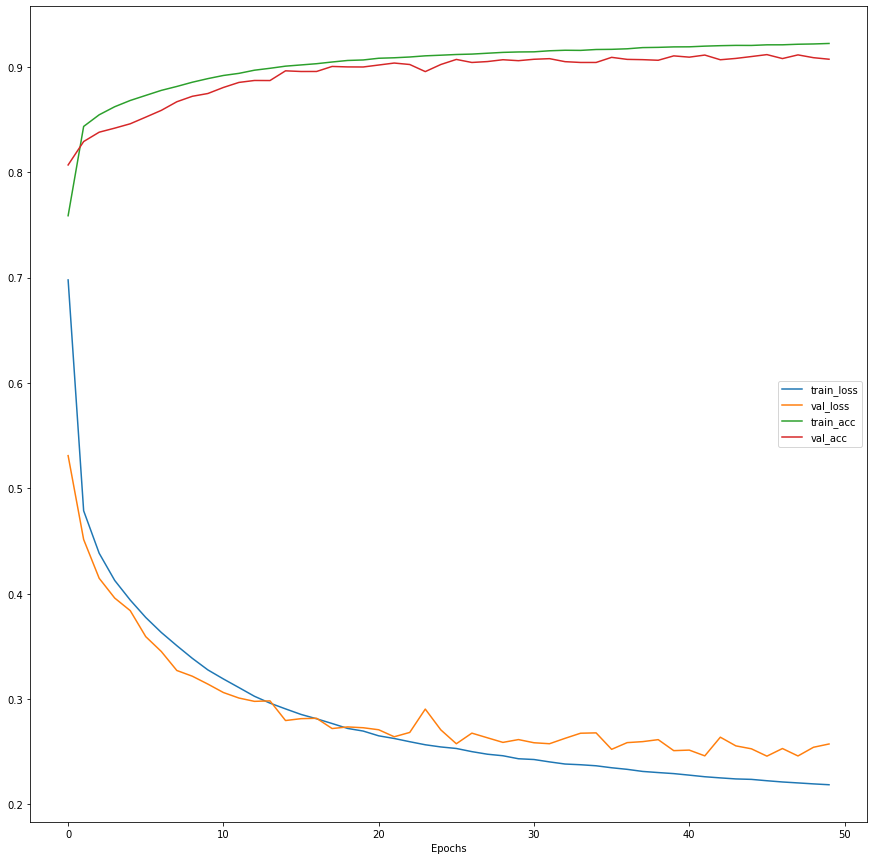

In [ ]:
printGraph()